In [1]:
from mdgan import MDGAN

/Users/je714/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/je714/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/je714/miniconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored class

In [2]:
from msmbuilder.example_datasets import AlanineDipeptide


/Users/je714/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
%matplotlib inline
import seaborn as sns

Load up several dialanine MD trajectories.

In [4]:
trjs = AlanineDipeptide().get().trajectories

alanine_dipeptide already is cached


In [5]:
from utils import make_trajectory_trainable

Get the coordinates of the trajectories in a -1 to 1 squished space to be trainable in the GAN.

In [6]:
data, sc = make_trajectory_trainable(trjs)  # sc is the MinMaxScaler we'll need it later

In [7]:
gan = MDGAN(n_atoms=22)

Train some epochs of the gan and store the generator and discriminator BCE losses.

In [8]:
losses = gan.train(data, num_epochs=50)

/Users/je714/miniconda3/lib/python3.6/site-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:   1/50 Discriminator Loss: 0.0052 Generator Loss: 11.2788
Epoch:   2/50 Discriminator Loss: 0.0027 Generator Loss: 12.3420
Epoch:   3/50 Discriminator Loss: 0.0400 Generator Loss: 6.1206
Epoch:   4/50 Discriminator Loss: 0.1186 Generator Loss: 3.6868
Epoch:   5/50 Discriminator Loss: 0.2824 Generator Loss: 2.9040
Epoch:   6/50 Discriminator Loss: 0.3616 Generator Loss: 2.2916
Epoch:   7/50 Discriminator Loss: 0.4579 Generator Loss: 2.6663
Epoch:   8/50 Discriminator Loss: 0.5261 Generator Loss: 2.9221
Epoch:   9/50 Discriminator Loss: 0.3723 Generator Loss: 3.3612
Epoch:  10/50 Discriminator Loss: 0.3342 Generator Loss: 4.1194
Epoch:  11/50 Discriminator Loss: 0.2023 Generator Loss: 5.0571
Epoch:  12/50 Discriminator Loss: 0.2241 Generator Loss: 5.0300
Epoch:  13/50 Discriminator Loss: 0.3090 Generator Loss: 4.7707
Epoch:  14/50 Discriminator Loss: 0.1013 Generator Loss: 6.1205
Epoch:  15/50 Discriminator Loss: 0.2138 Generator Loss: 5.4227
Epoch:  16/50 Discriminator Loss: 0.33

In [9]:
from utils import plot_losses

(<matplotlib.figure.Figure at 0x12e8d4390>,
 <matplotlib.axes._subplots.AxesSubplot at 0x134386da0>)

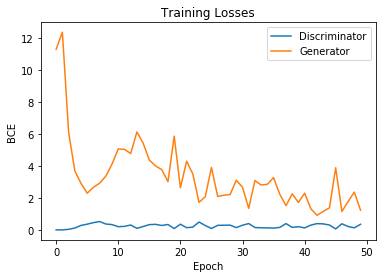

In [10]:
plot_losses(losses)

We can see how the generator quickly gets better at faking conformations whilst the discriminator appears to stabilize much faster.

Let's generate 10000 fake conformations with the GAN and see how they compare to actual structures.

To do that, create a ten thousand 100-dimensional input vectors to pass into the generator, and get predictions out of it.

In [11]:
from utils import make_latent_samples, fake_traj_from_samples

In [53]:
samples = gan.generator.predict(make_latent_samples(10000, 100))

In [54]:
fake_traj = fake_traj_from_samples(samples, trjs[0].topology, scaler=sc)

In [55]:
fake_traj.save_netcdf('fake_traj_ala2.nc')

In [56]:
fake_traj

<mdtraj.Trajectory with 10000 frames, 22 atoms, 3 residues, without unitcells at 0x13f91e128>

We can visualize the conformations obtained from the GAN and compare them to the real ones.
Additionally we can measure structural properties from them.

In [57]:
from msmbuilder.featurizer import DihedralFeaturizer

In [58]:
feat = DihedralFeaturizer(sincos=False)
fake_ftraj = feat.fit_transform([fake_traj])
real_ftraj = feat.fit_transform([trjs[0]])

In [59]:
import msmexplorer as msme

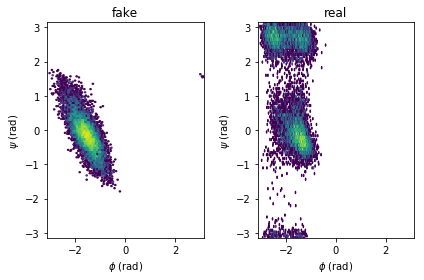

In [78]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hexbin(fake_ftraj[0][:, 0], fake_ftraj[0][:, 1], bins='log', mincnt=1)
ax2.hexbin(real_ftraj[0][:, 0], real_ftraj[0][:, 1], bins='log', mincnt=1)
ax1.set(xlim=[-np.pi, np.pi], ylim=[-np.pi, np.pi], title='fake', xlabel='$\phi$ (rad)', ylabel='$\psi$ (rad)',);
ax2.set(xlim=[-np.pi, np.pi], ylim=[-np.pi, np.pi], title='real', xlabel='$\phi$ (rad)', ylabel='$\psi$ (rad)');
f.tight_layout()

It looks like the GAN has failed to capture the $\psi$ dihedral angle which is a rare event.